<a href="https://colab.research.google.com/github/konderal333/HGT-2022-EmDomArDon/blob/main/HGT_frequency_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/konderal333/HGT-2022-EmDomArDon.git

Cloning into 'HGT-2022-EmDomArDon'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 211 (delta 31), reused 17 (delta 5), pack-reused 151
Receiving objects: 100% (211/211), 21.68 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Checking out files: 100% (13/13), done.


In [2]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install simplemma
import simplemma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.2 MB 74 kB/s 


In [4]:
# loading the pre-trained solutions
results = pd.read_excel('/content/HGT-2022-EmDomArDon/results/results_pre_trained.xlsx')

In [5]:
results.head()

,Lead,pred_summary,Textbody
0,Elkezdi az illegális bevándorlók Ruandába depo...,"Ruandába akarnak átutazni, mert a brit kormány...",Ezen a héten kezdik meg a brit határt illegáli...
1,Már idén jöhetnek a hirdetések a Netflixre. Eg...,A Netflix dolgozóinak küldött feljegyzés szeri...,Már az év végén megjelenhetnek a reklámok a Ne...
2,"Ukrán tájba fúródott kazettás bomba, Putyin ke...",Az ukrán hadsereg kedden folytatta a harcokat ...,Az orosz erők kedden tovább ostromolták a mari...
3,Elon Musk visszaengedné Donald Trumpot a Twitt...,"Elon Musk szerint hiba volt, hogy nem volt hel...",Elon Musk visszaállítaná Donald Trump korábbi ...
4,Meghalt a független Ukrajna első elnöke. Leony...,Leonyid Kravcsuk volt a kulcsfigura.,"Meghalt Leonyid Kravcsuk, a független Ukrajna ..."


In [6]:
# stop words to filter out
stop_words = set(stopwords.words('hungarian'))

## On the original textbodies

In [7]:
rel_occurences = []

results = results.apply(lambda x: x.str.lower())

for index, row in results.iterrows():
  # fixing missings whitespaces between sentences
  pred = re.sub(r"(\.)([A-Z])", r'\1 \2', row['pred_summary']) 
  body = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Textbody'])

  # tokenizing the prediction summary
  pred_tokens = []
  for sen in nltk.tokenize.sent_tokenize(pred):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    filtered_sen = [w for w in tokenized_sen if not w in stop_words] # eliminating stop words
    pred_tokens = pred_tokens + filtered_sen
  
  # tokenizing the textbody
  body_tokens = []
  for sen in nltk.tokenize.sent_tokenize(body):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    body_tokens = body_tokens + tokenized_sen

  #calculating the relative occurences
  text_len = len(body_tokens)
  for word1 in set(pred_tokens):
    for place, word2 in enumerate(body_tokens):
      if simplemma.lemmatize(word1, lang='hu') == simplemma.lemmatize(word2, lang='hu'):
        rel_occurences.append(place/text_len)

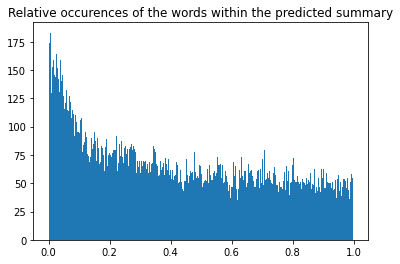

In [8]:
import matplotlib.pyplot as plt
plt.hist(rel_occurences, bins=300)
plt.title('Relative occurences of the words within the predicted summary')
plt.show()

In [9]:
# now do the same for the original leads
rel_occurences_2 = []

for index, row in results.iterrows():
  # fixing missings whitespaces between sentences
  lead = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Lead']) 
  body = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Textbody'])

  # tokenizing the leads
  lead_tokens = []
  for sen in nltk.tokenize.sent_tokenize(lead):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    filtered_sen = [w for w in tokenized_sen if not w in stop_words] # eliminating stop words
    lead_tokens = lead_tokens + filtered_sen
  
  # tokenizing the textbody
  body_tokens = []
  for sen in nltk.tokenize.sent_tokenize(body):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    body_tokens = body_tokens + tokenized_sen

  #calculating the relative occurences
  text_len = len(body_tokens)
  for word1 in set(lead_tokens):
    for place, word2 in enumerate(body_tokens):
      if simplemma.lemmatize(word1, lang='hu') == simplemma.lemmatize(word2, lang='hu'):
        rel_occurences_2.append(place/text_len)

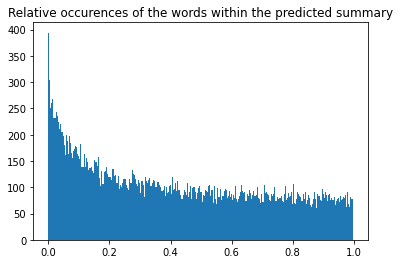

In [10]:
import matplotlib.pyplot as plt
plt.hist(rel_occurences_2, bins=300)
plt.title('Relative occurences of the words within the predicted summary')
plt.show()

## On the modified textbodies

Data preparation

In [11]:
%%capture
!pip install transformers
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('SZTAKI-HLT/hubert-base-cc')

In [12]:
def text_to_token_list(art_title, x):      
  token_list = []
  sen_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences
 
  for sen in nltk.tokenize.sent_tokenize(x):
    token_list.append(tokenizer.tokenize(sen))
    sen_list.append(sen)

  return token_list, sen_list

In [13]:
dict_of_tokens = {} 
#this dict will contain the article title as keys and the tokenized lists from the function below as values for other purposes

def text_to_tokens(art_title, x):      
  #insert the text to tokenize; first breaks text into sentences, then makes a list of lists with the i-th element being the tokenization of the i-th sentence
  token_list = []

  x = re.sub(r"(\.)([A-Z])", r'\1 \2', x) # fixes missings whitespaces between sentences

  tokens, sentences = text_to_token_list(art_title, x)  #tokens and sentences

  new_text = ''      #this is the text which contains less than (or equal to) 510 tokens

  #total tokennumber
  len1 = 0
  for i in tokens:
    for j in i:
      len1 += 1

  #if the text is > 510 tokens, we will get the first few whole sentences (~255 tokens), and the last few whole sentences (~255 tokens)
  if len1 > 510:
    begin_sum = 0
    begin_tokens = []
    for index, elem1 in enumerate(tokens):
      if begin_sum + len(elem1) > 255:
        break
      else:
        begin_sum += len(elem1)
        begin_tokens.append(elem1)
        new_text = new_text + sentences[index] + " "   #appending the new text  

    end_indexes = []
    end_sum = 0
    end_tokens = []
    tokens.reverse()
    for index, elem2 in enumerate(tokens):
      if end_sum + len(elem2) > 510-begin_sum:
        break
      else:
        end_sum += len(elem2)
        end_tokens.append(elem2)
        end_indexes.append(-index-1)

    #finally reconstructing the text which has less than (or equal to) 510 tokens 
    end_indexes.reverse()
    for end_index in end_indexes:
      new_text = new_text + sentences[end_index] + " "


    end_tokens.reverse()
    final_tokens = []
    for elem3 in begin_tokens:
      final_tokens.append(elem3)
    for elem4 in end_tokens:
      final_tokens.append(elem4)

    dict_of_tokens[art_title] = final_tokens
    return new_text.strip()

  #if the text is < 510 tokens, we do not have to get the beginning and the end, we can use the whole text
  else:
    for sen in nltk.tokenize.sent_tokenize(x):
      new_text = new_text + sen + " "
      token_list.append(tokenizer.tokenize(sen))

    dict_of_tokens[art_title] = token_list
    return new_text.strip()

In [14]:
# making the BERT tokenized sentences and the reduced sentences from each article
results2 = pd.read_excel('/content/HGT-2022-EmDomArDon/results/results_pre_trained.xlsx')

for i in range(len(results2.Lead)):
  new_text = text_to_tokens(results2.Lead[i].strip(), results.Textbody[i])
  results2.at[i, 'Textbody'] = new_text

Now the frequencies

In [15]:
rel_occurences_3 = []

results2 = results2.apply(lambda x: x.str.lower())

for index, row in results2.iterrows():
  # fixing missings whitespaces between sentences
  pred = re.sub(r"(\.)([A-Z])", r'\1 \2', row['pred_summary']) 
  body = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Textbody'])

  # tokenizing the prediction summary
  pred_tokens = []
  for sen in nltk.tokenize.sent_tokenize(pred):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    filtered_sen = [w for w in tokenized_sen if not w in stop_words] # eliminating stop words
    pred_tokens = pred_tokens + filtered_sen
  
  # tokenizing the textbody
  body_tokens = []
  for sen in nltk.tokenize.sent_tokenize(body):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    body_tokens = body_tokens + tokenized_sen

  #calculating the relative occurences
  text_len = len(body_tokens)
  for word1 in set(pred_tokens):
    for place, word2 in enumerate(body_tokens):
      if simplemma.lemmatize(word1, lang='hu') == simplemma.lemmatize(word2, lang='hu'):
        rel_occurences_3.append(place/text_len)

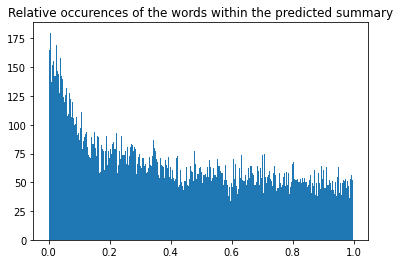

In [16]:
import matplotlib.pyplot as plt
plt.hist(rel_occurences_3, bins=300)
plt.title('Relative occurences of the words within the predicted summary')
plt.show()

In [17]:
# now do the same for the original leads
rel_occurences_4 = []

for index, row in results2.iterrows():
  # fixing missings whitespaces between sentences
  lead = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Lead']) 
  body = re.sub(r"(\.)([A-Z])", r'\1 \2', row['Textbody'])

  # tokenizing the leads
  lead_tokens = []
  for sen in nltk.tokenize.sent_tokenize(lead):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    filtered_sen = [w for w in tokenized_sen if not w in stop_words] # eliminating stop words
    lead_tokens = lead_tokens + filtered_sen
  
  # tokenizing the textbody
  body_tokens = []
  for sen in nltk.tokenize.sent_tokenize(body):
    tokenized_sen = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sen)
    body_tokens = body_tokens + tokenized_sen

  #calculating the relative occurences
  text_len = len(body_tokens)
  for word1 in set(lead_tokens):
    for place, word2 in enumerate(body_tokens):
      if simplemma.lemmatize(word1, lang='hu') == simplemma.lemmatize(word2, lang='hu'):
        rel_occurences_4.append(place/text_len)

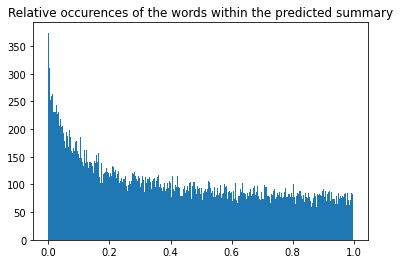

In [18]:
import matplotlib.pyplot as plt
plt.hist(rel_occurences_4, bins=300)
plt.title('Relative occurences of the words within the predicted summary')
plt.show()

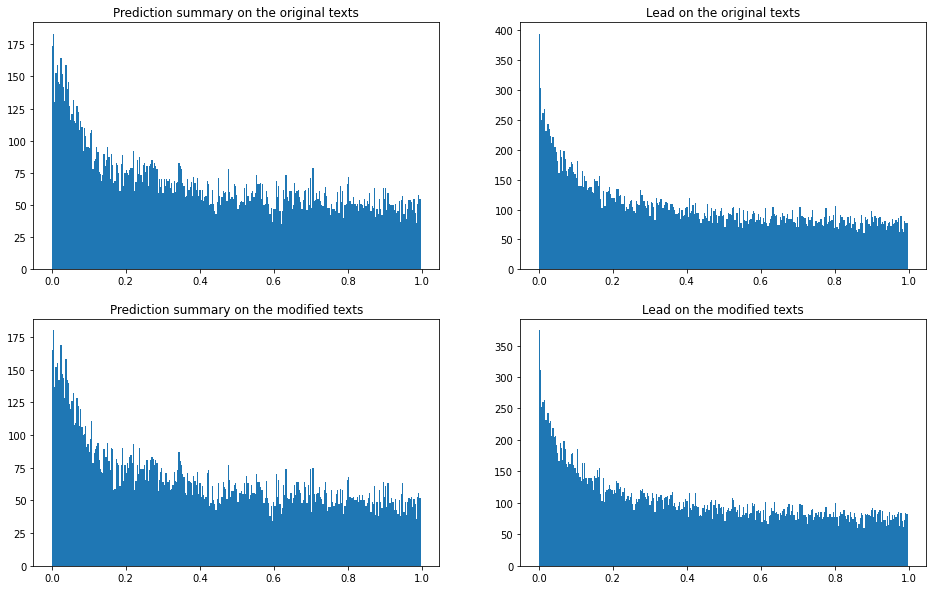

In [19]:
# now all histograms altogether
fig, axes = plt.subplots(2,2, figsize=(16,10))
axes[0,0].hist(rel_occurences, bins = 300)
axes[0,0].set_title('Prediction summary on the original texts')
axes[0,1].hist(rel_occurences_2, bins = 300)
axes[0,1].set_title('Lead on the original texts')
axes[1,0].hist(rel_occurences_3, bins = 300)
axes[1,0].set_title('Prediction summary on the modified texts')
axes[1,1].hist(rel_occurences_4, bins = 300)
axes[1,1].set_title('Lead on the modified texts')
plt.show()

In [19]:
# TODO: the same but with TF-IDF weighting